In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('../Data/Loan_default.csv')

In [3]:
data

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [5]:
data['Default'].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [6]:
def convert_to_idr(amount_usd, exchange_rate=15358):
    return amount_usd * exchange_rate

usd_columns = ['Income', 'LoanAmount']
data[usd_columns] = data[usd_columns].apply(lambda x: convert_to_idr(x))
print(data)

            LoanID  Age      Income  LoanAmount  CreditScore  MonthsEmployed  \
0       I38PQUQS96   56  1320695852   776915146          520              80   
1       HPSK72WA7R   69   774534656  1911149520          458              15   
2       C1OZ6DPJ8Y   46  1293266464  1984069304          451              26   
3       V2KKSFM3UN   32   487048254   688023042          743               0   
4       EY08JDHTZP   60   313871446   140356762          633               8   
...            ...  ...         ...         ...          ...             ...   
255342  8C6S86ESGC   19   583281482  3235654156          541             109   
255343  98R4KDHNND   32   797894174  2916468842          511              14   
255344  XQK1UUUNGP   56  1302665560  3198979252          597              70   
255345  JAO28CPL4H   42  1307104022   930310850          809              40   
255346  ZTH91CGL0B   62   344295644   283831198          636             113   

        NumCreditLines  InterestRate  L

In [7]:
data['Income'].max()

2303684642

In [8]:
data[data['Income'] == 2303684642]

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
183400,ZQGVAT7T79,59,2303684642,1345744750,344,98,2,2.58,12,0.72,Bachelor's,Part-time,Single,No,No,Business,No,0
252244,VOXXF484TC,29,2303684642,2576534870,387,68,3,10.70,36,0.83,High School,Part-time,Single,Yes,Yes,Other,No,0


In [9]:
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

np.save('../App/Model/encoder.npy', le.classes_)
joblib.dump(label_encoders, '../App/Model/encoder.pkl')

['../App/Model/encoder.pkl']

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  int64  
 11  EmploymentType  255347 non-null  int64  
 12  MaritalStatus   255347 non-null  int64  
 13  HasMortgage     255347 non-null  int64  
 14  HasDependents   255347 non-null  int64  
 15  LoanPurpose     255347 non-null  int64  
 16  HasCoSigner     255347 non-null  int64  
 17  Default   

In [11]:
data.drop(axis=1,inplace=True,columns='LoanID')
data.dropna(inplace=True)

In [12]:
label = data.pop('Default')

In [13]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data, label)

X_resampled.reset_index()
y_resampled.reset_index()
# Combine resampled features and target into a new DataFrame
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

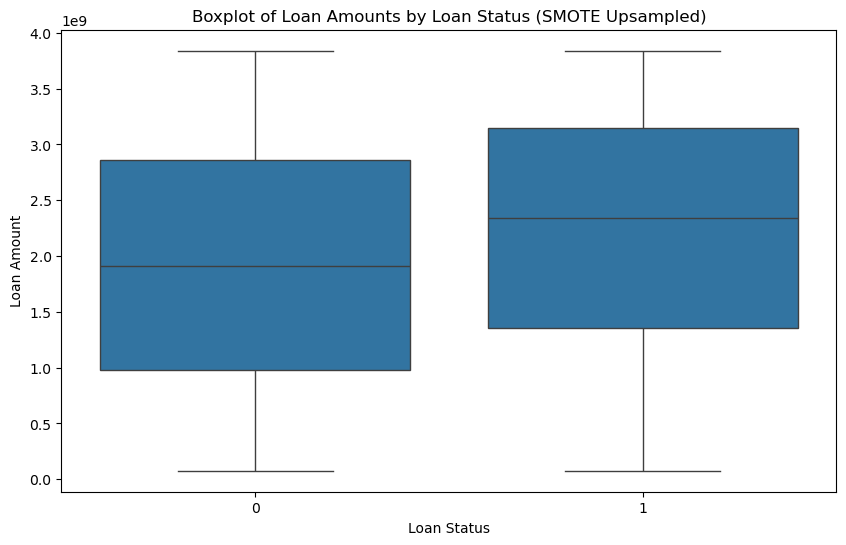

In [14]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = resampled_data['LoanAmount'].quantile(0.25)
Q3 = resampled_data['LoanAmount'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
resampled_filtered = resampled_data[(resampled_data['LoanAmount'] >= lower_bound) & (resampled_data['LoanAmount'] <= upper_bound)]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Default', y='LoanAmount', data=resampled_filtered)
plt.title('Boxplot of Loan Amounts by Loan Status (SMOTE Upsampled)')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.show()

In [15]:
resampled_label = resampled_data.pop('Default')

In [16]:
data_train, data_test, label_train, label_test = train_test_split(resampled_data, resampled_label, test_size=0.2, random_state=42)

In [17]:
print("Train\t: ",data_train.shape[0])
print("Test\t: ",data_test.shape[0])

Train	:  361110
Test	:  90278


In [18]:
numerical_columns = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical columns
data_train[numerical_columns] = scaler.fit_transform(data_train[numerical_columns])

# Transform the test data using the same scaler (fitted on training data)
data_test[numerical_columns] = scaler.transform(data_test[numerical_columns])

joblib.dump(scaler, '../App/Model/scaler.bin', compress=True)

['../App/Model/scaler.bin']

In [19]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [20]:
# # Define the DecisionTreeClassifier
# tree = DecisionTreeClassifier()

# # Define the parameter grid for RandomizedSearchCV
# parameter = {
#     "criterion": ["gini", "entropy"],
#     "max_depth": list(range(1, 21)) + [None],
#     "min_samples_split": list(range(2, 21)),
#     "min_samples_leaf": list(range(1, 21)),
#     "max_features": [None, "auto", "sqrt", "log2"],
#     "class_weight": [None, "balanced"]
# }

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=tree,
#                                    param_distributions=parameter,
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    scoring=scoring,
#                                    refit='accuracy',  # Which metric to use for refitting the best model
#                                    cv=5,  # 5-fold cross-validation
#                                    verbose=3,
#                                    n_jobs=-1,
#                                    random_state=42)  # For reproducibility

# # Fit RandomizedSearchCV
# random_search.fit(data_train, label_train)

# # Print the best parameters and best score
# print("Best Parameters:", random_search.best_params_)
# print("Best Cross-Validation Accuracy:", random_search.best_score_)

In [21]:
# # Define the RandomForestClassifier
# forest = RandomForestClassifier()

# # Define the parameter grid for RandomizedSearchCV for RandomForestClassifier
# forest_param = {
#     'n_estimators': range(100, 501, 100),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': range(10, 51, 10),
#     'min_samples_split': range(2, 21),
#     'min_samples_leaf': range(1, 21),
#     'bootstrap': [True, False],
#     'random_state': [42]
# }

# # Initialize RandomizedSearchCV for RandomForestClassifier
# random_search_forest = RandomizedSearchCV(estimator=forest,
#                                           param_distributions=forest_param,
#                                           n_iter=100,
#                                           scoring=scoring,
#                                           refit='accuracy',
#                                           cv=5,
#                                           verbose=3,
#                                           n_jobs=-1,
#                                           random_state=42)

# # Fit RandomizedSearchCV for RandomForestClassifier
# random_search_forest.fit(data_train, label_train)

# # Print the best parameters and best score for RandomForestClassifier
# print("Best Parameters for RandomForestClassifier:", random_search_forest.best_params_)
# print("Best Cross-Validation Accuracy for RandomForestClassifier:", random_search_forest.best_score_)

In [22]:
# # Define the GradientBoostingClassifier
# xgboost = GradientBoostingClassifier()

# # Define the parameter grid for RandomizedSearchCV for GradientBoostingClassifier
# xgboost_param = {
#     'n_estimators': range(100, 501, 100),
#     'learning_rate': np.arange(0.01, 0.2, 0.01),
#     'max_depth': range(3, 21, 2),
#     'min_samples_split': range(2, 21),
#     'min_samples_leaf': range(1, 21),
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'random_state': [42]
# }

# # Initialize RandomizedSearchCV for GradientBoostingClassifier
# random_search_xgboost = RandomizedSearchCV(estimator=xgboost,
#                                            param_distributions=xgboost_param,
#                                            n_iter=100,
#                                            scoring=scoring,
#                                            refit='accuracy',
#                                            cv=5,
#                                            verbose=3,
#                                            n_jobs=-1,
#                                            random_state=42)

# # Fit RandomizedSearchCV for GradientBoostingClassifier
# random_search_xgboost.fit(data_train, label_train)

# # Print the best parameters and best score for GradientBoostingClassifier
# print("Best Parameters for GradientBoostingClassifier:", random_search_xgboost.best_params_)
# print("Best Cross-Validation Accuracy for GradientBoostingClassifier:", random_search_xgboost.best_score_)

In [23]:
tree = DecisionTreeClassifier(min_samples_split= 18, min_samples_leaf= 19, max_features= None, max_depth= 18, criterion= 'entropy', class_weight= 'balanced')
tree.fit(data_train, label_train)
tree_pred = tree.predict(data_test)
joblib.dump(tree, '../App/Model/decision_tree_model.pkl')

['../App/Model/decision_tree_model.pkl']

In [24]:
forest = RandomForestClassifier()
forest.fit(data_train, label_train)
forest_pred = forest.predict(data_test)
joblib.dump(tree, '../App/Model/random_forest_model.pkl')

['../App/Model/random_forest_model.pkl']

In [25]:
xgboost = GradientBoostingClassifier()
xgboost.fit(data_train, label_train)
xgboost_pred = xgboost.predict(data_test)
joblib.dump(tree, '../App/Model/xgboost_model.pkl')

['../App/Model/xgboost_model.pkl']

In [26]:
report_1 = classification_report(label_test, tree_pred)
print('Hasil Model Decision Tree')
print(report_1)

Hasil Model Decision Tree
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     45127
           1       0.84      0.81      0.82     45151

    accuracy                           0.83     90278
   macro avg       0.83      0.83      0.83     90278
weighted avg       0.83      0.83      0.83     90278



In [27]:
report_2 = classification_report(label_test, forest_pred)
print('Hasil Model Random Forest')
print(report_2)

Hasil Model Random Forest
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     45127
           1       0.90      0.85      0.88     45151

    accuracy                           0.88     90278
   macro avg       0.88      0.88      0.88     90278
weighted avg       0.88      0.88      0.88     90278



In [28]:
report_3 = classification_report(label_test, xgboost_pred)
print('Hasil Model XGBoost')
print(report_3)

Hasil Model XGBoost
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     45127
           1       0.91      0.83      0.87     45151

    accuracy                           0.88     90278
   macro avg       0.88      0.88      0.88     90278
weighted avg       0.88      0.88      0.88     90278



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=034ae2da-e2cd-440b-bf98-a709e2f1e5b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>